In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
df_filepath = "..\\dataset\\new dataset.xlsx"
og_df = pd.read_excel(df_filepath)
print(og_df.head())

   Year  Month  Day Weekend?    Hour Collision Type         Injury Type  \
0  2015      1    5  Weekday     0.0          2-Car   No injury/unknown   
1  2015      1    6  Weekday  1500.0          2-Car   No injury/unknown   
2  2015      1    6  Weekend  2300.0          2-Car  Non-incapacitating   
3  2015      1    7  Weekend   900.0          2-Car  Non-incapacitating   
4  2015      1    7  Weekend  1100.0          2-Car   No injury/unknown   

                          Primary Factor      Reported_Location   Latitude  \
0  OTHER (DRIVER) - EXPLAIN IN NARRATIVE             1ST & FESS  39.159207   
1                  FOLLOWING TOO CLOSELY          2ND & COLLEGE  39.161440   
2              DISREGARD SIGNAL/REG SIGN  BASSWOOD & BLOOMFIELD  39.149780   
3          FAILURE TO YIELD RIGHT OF WAY         GATES & JACOBS  39.165655   
4          FAILURE TO YIELD RIGHT OF WAY                  W 3RD  39.164848   

   Longitude  
0 -86.525874  
1 -86.534848  
2 -86.568890  
3 -86.575956  
4 -86

**NOTE:**

Will clean data for collisions df and separate df to demonstate that Weekend? is unecessary during EDA

# df Cleaning
**Feature Selection**
Provided columns are 'Year', 'Month', 'Day', 'Weekend?', 'Hour', 'Collision Type', 'Injury Type','Primary Factor', 'Reported_Location', 'Latitude', 'Longitude'. We will drop 'Collision Type', 'Injury Type', and 'Primary Factor' since these values will not help us determine whether or not an accident will happen (because these features only exist in the case that an accident does occur). We will drop 'Year' since we want our model to generalize to any given year. We will drop 'Weekend?' since that information is already accounted for by the 'Day' variable and 'Reported_Location' since that information is given by the longitude and latitude.

**Removing Rows with Empty Values**
We will also drop any rows with empty values in the selected features

In [5]:
df = og_df.drop(columns=['Year', 'Weekend?', 'Primary Factor', 'Collision Type', 'Injury Type', 'Reported_Location'])
injuries_df = og_df.drop(columns=['Year', 'Reported_Location'])

df = df.dropna()
injuries_df = injuries_df.dropna()
print(df.head())

   Month  Day    Hour   Latitude  Longitude
0      1    5     0.0  39.159207 -86.525874
1      1    6  1500.0  39.161440 -86.534848
2      1    6  2300.0  39.149780 -86.568890
3      1    7   900.0  39.165655 -86.575956
4      1    7  1100.0  39.164848 -86.579625


# Normalizing Data
**Normalizing Hours**

Disregarding decimal points, Hour values are currently 3-4 characters with the least significant 2 digits being minutes (always 00 in this dataset) and the remaining significant bits denoting hours. We will remove decimal point and remove minutes integers so that the only remaining number is what number hour it is (from 0 to 23).

In [6]:
# We must normalize all values in hour column such that it is 4 integers indicating the format (HH:MM)
df['Hour'] = df['Hour'].astype(int).astype(str).str.zfill(4)

# get just the HH values (indicates which of the 24 buckets the value goes into)
df['Hour'] = df['Hour'].str[:2].astype(int)

print(df)

# replicate for injuries df
# We must normalize all values in hour column such that it is 4 integers indicating the format (HH:MM)
injuries_df['Hour'] = injuries_df['Hour'].astype(int).astype(str).str.zfill(4)

# get just the HH values (indicates which of the 24 buckets the value goes into)
injuries_df['Hour'] = injuries_df['Hour'].str[:2].astype(int)

       Month  Day  Hour   Latitude  Longitude
0          1    5     0  39.159207 -86.525874
1          1    6    15  39.161440 -86.534848
2          1    6    23  39.149780 -86.568890
3          1    7     9  39.165655 -86.575956
4          1    7    11  39.164848 -86.579625
...      ...  ...   ...        ...        ...
53938     10    6    17   0.000000   0.000000
53939     11    3     8   0.000000   0.000000
53940     12    5    12   0.000000   0.000000
53941     12    1     7   0.000000   0.000000
53942     12    7    17   0.000000   0.000000

[53688 rows x 5 columns]


**Encoding Weekend?**

In [7]:
weekend_mapping = {'Weekday':0, 'Weekend':1}
injuries_df['Weekend?'] = injuries_df['Weekend?'].replace(weekend_mapping)
print(injuries_df.head())

   Month  Day  Weekend?  Hour Collision Type         Injury Type  \
0      1    5         0     0          2-Car   No injury/unknown   
1      1    6         0    15          2-Car   No injury/unknown   
2      1    6         1    23          2-Car  Non-incapacitating   
3      1    7         1     9          2-Car  Non-incapacitating   
4      1    7         1    11          2-Car   No injury/unknown   

                          Primary Factor   Latitude  Longitude  
0  OTHER (DRIVER) - EXPLAIN IN NARRATIVE  39.159207 -86.525874  
1                  FOLLOWING TOO CLOSELY  39.161440 -86.534848  
2              DISREGARD SIGNAL/REG SIGN  39.149780 -86.568890  
3          FAILURE TO YIELD RIGHT OF WAY  39.165655 -86.575956  
4          FAILURE TO YIELD RIGHT OF WAY  39.164848 -86.579625  


C:\Users\Sajid M\AppData\Local\Temp\ipykernel_10416\1264556025.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  injuries_df['Weekend?'] = injuries_df['Weekend?'].replace(weekend_mapping)


# Identifying Outliers

c:\Users\Sajid M\miniconda3\envs\ecs171\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


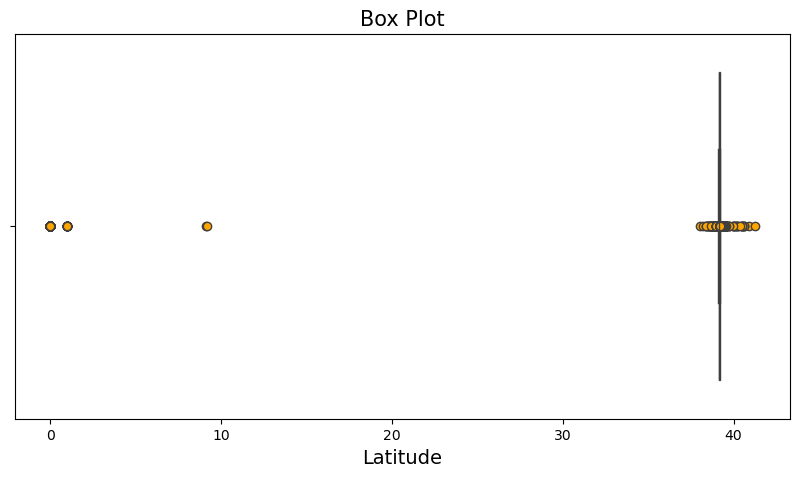

0.0 41.22866547


c:\Users\Sajid M\miniconda3\envs\ecs171\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


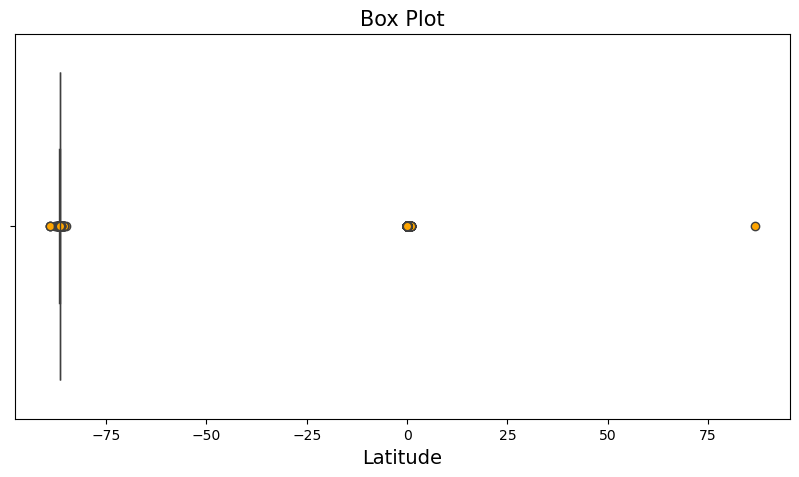

0.0 41.22866547


In [8]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(x = df['Latitude'], flierprops = dict(markerfacecolor = 'orange', marker = 'o'))
plt.title('Box Plot', fontsize=15)
plt.xlabel('Latitude', fontsize=14)
plt.show()

print(df['Latitude'].min(), df['Latitude'].max())

fig = plt.figure(figsize=(10,5))
sns.boxplot(x = df['Longitude'], flierprops = dict(markerfacecolor = 'orange', marker = 'o'))
plt.title('Box Plot', fontsize=15)
plt.xlabel('Latitude', fontsize=14)
plt.show()
print(df['Latitude'].min(), df['Latitude'].max())

**Issue:**

There are very clearly a lot of outliers in this data, and many of these longitudes/latitude pairs are located in areas that don't make sense for the dataset (e.g. in Africa instead of Indianapolis). To manage this issue without paying for API access to verify each longitude/latitude is within reasonable limits, we will remove values where they are outside of one standard deviation of the mean. Upon inspection, the range of values for longitude and latitude after this removal seems reasonable and acceptable for the scope of this project.

In [9]:
mean_longitude = df['Longitude'].mean()
std_longitude = df['Longitude'].std()
threshold = std_longitude

# Create a boolean mask to identify rows where "Longitude" is within the threshold
mask = (df['Longitude'] >= (mean_longitude - threshold)) & (df['Longitude'] <= (mean_longitude + threshold))
# apply mask
filtered_df = df[mask]

mean_latitude = df['Latitude'].mean()
std_latitude = df['Latitude'].std()
threshold = std_latitude

# Create a boolean mask to identify rows where "Longitude" is within the threshold
mask = (filtered_df['Latitude'] >= (mean_latitude - threshold)) & (filtered_df['Latitude'] <= (mean_latitude + threshold))
# apply mask
filtered_df = filtered_df[mask]

print(df.shape)
# Print the filtered DataFrame
print(filtered_df.shape)

#
#
# replicate for injuries df
mean_longitude = injuries_df['Longitude'].mean()
std_longitude = injuries_df['Longitude'].std()
threshold = std_longitude

# Create a boolean mask to identify rows where "Longitude" is within the threshold
mask = (injuries_df['Longitude'] >= (mean_longitude - threshold)) & (injuries_df['Longitude'] <= (mean_longitude + threshold))
# apply mask
filtered_inj_df = injuries_df[mask]

mean_latitude = injuries_df['Latitude'].mean()
std_latitude = injuries_df['Latitude'].std()
threshold = std_latitude

# Create a boolean mask to identify rows where "Longitude" is within the threshold
mask = (filtered_inj_df['Latitude'] >= (mean_latitude - threshold)) & (filtered_inj_df['Latitude'] <= (mean_latitude + threshold))
# apply mask
filtered_inj_df = filtered_inj_df[mask]


(53688, 5)
(48782, 5)


c:\Users\Sajid M\miniconda3\envs\ecs171\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


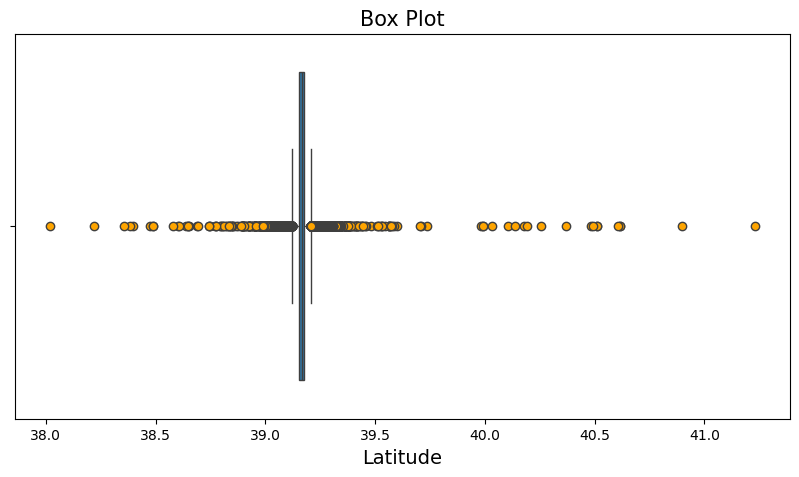

38.01932812 41.22866547


c:\Users\Sajid M\miniconda3\envs\ecs171\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


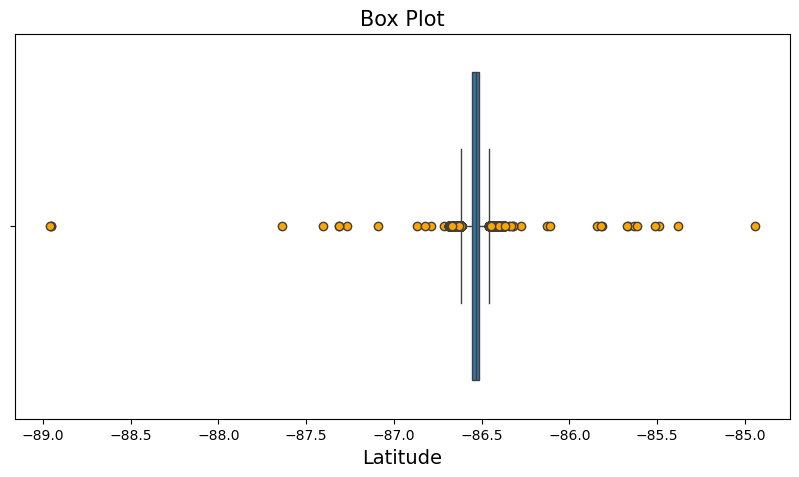

-88.959213 -84.94479


In [10]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(x = filtered_df['Latitude'], flierprops = dict(markerfacecolor = 'orange', marker = 'o'))
plt.title('Box Plot', fontsize=15)
plt.xlabel('Latitude', fontsize=14)
plt.show()

print(filtered_df['Latitude'].min(), filtered_df['Latitude'].max())

fig = plt.figure(figsize=(10,5))
sns.boxplot(x = filtered_df['Longitude'], flierprops = dict(markerfacecolor = 'orange', marker = 'o'))
plt.title('Box Plot', fontsize=15)
plt.xlabel('Latitude', fontsize=14)
plt.show()
print(filtered_df['Longitude'].min(), filtered_df['Longitude'].max())

# Save Modified Data

Will save modified data to a CSV file for use by our model

In [11]:
filtered_df.to_csv('.\\modified_data\\cleaned_data.csv', index=False)
filtered_inj_df.to_csv('.\\modified_data\\cleaned_injury_data.csv', index=False)

print(filtered_df.shape)
print(filtered_inj_df.shape)

(48782, 5)
(47807, 9)
